# Training an entity linking classifier: V&A

(ignore the markdown - it's copied from `./train classifier.ipynb`)

In [1]:
!pip install openpyxl textdistance

You should consider upgrading via the '/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/bin/python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../..")

import pandas as pd
import numpy as np
import seaborn as sns

import textdistance
from Levenshtein import distance, ratio
from fuzzywuzzy import fuzz

from hc_nlp.constants import ORG_LEGAL_SUFFIXES
from heritageconnector.nlp.nel import NELFeatureGenerator

# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

2021-09-07 14:51:49,026 - heritageconnector.datastore - DEBUG - Connected to Elasticsearch cluster at https://c4241473f2f84e2ab15c5b7c81eb34a4.eu-west-1.aws.found.io:9243/


In [3]:
# SMG
# fpath = "../../../GITIGNORE_DATA/NEL/nel_train_data_20210610-1035_combined_with_review_data_fixed.xlsx"

# V&A
fpath = "../../../GITIGNORE_DATA/vanda_hc_data/NEL/nel_train_data_manual_20210829-0102_annotated.xlsx"

df = pd.read_excel(fpath, index_col=0)


df.loc[~df['link_correct'].isnull(), 'link_correct'] = df.loc[~df['link_correct'].isnull(), 'link_correct'].apply(int)
# df = df.drop(columns=["item_uri.1", "candidate_uri.1"])
df['ent_label'] = df['ent_label'].map({"PERSON": "PERSON", "OBJECT": "OBJECT", "ORG": "ORGANISATION"})
df['link_correct'] = df['link_correct'].map({0: False, 1: True})
df['_type_match'] = (df['ent_label'] == df['candidate_type'])
df[["ent_text", "candidate_title"]] = df[["ent_text", "candidate_title"]].astype(str)
df['_ent_candidate_distance'] = df.apply(lambda x: distance(x["ent_text"], x["candidate_title"]), axis=1)
df['_ent_candidate_similarity'] = df.apply(lambda x: ratio(x["ent_text"], x["candidate_title"]), axis=1)
df['_ent_candidate_sorted_similarity'] = df.apply(lambda x: fuzz.token_sort_ratio(x["ent_text"], x["candidate_title"])/100, axis=1)

df_annotated_not_in_search = df[df['candidate_rank'] == -1]
df_annotated = df[(~df['link_correct'].isnull()) & (df['candidate_rank'] != -1)]

df_unannotated = df[df['link_correct'].isnull()]

len(df), len(df_annotated), len(df_annotated_not_in_search), len(df_unannotated)

(150000, 2262, 0, 147738)

In [4]:
df_annotated.head()

,item_uri,item_uri_link,candidate_rank,item_description,ent_label,ent_text,candidate_title,candidate_type,candidate_uri,candidate_uri_link,link_correct,candidate_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity
0,https://api.vam.ac.uk/v2/objects/search?id_person=AUTH323930,https://api.vam.ac.uk/v2/objects/search?id_person=AUTH323930,0,"Ida and (Mary) Louise Cook were born in Sunderland in 1904 and 1901 respectively. After attending the Duchess' School in Alnwick they took civil service jobs in London and developed a passionate interest in opera. They came to know some of the leading singers and conductors - Amelita Galli-Curci, Enzio Pinza, Rosa Ponselle, Tito Gobbi and Maria Callas. They also came to know the Austrian conductor Clemens Krauss, and it was his wife, the singer Viorica Ursuleac who asked the sisters in 1934 to help a Jewish friend to leave Germany. Having accomplished this, the sisters continued the work of rescuing Jews and their property from Germany, pretending to be eccentric opera fanatics willing to go anywhere to hear a favourite artist. In 1965 the sisters were honoured for their rescue work and named among the 'Righteous Gentiles' by Yad Vashem Martyrs and Heroes' Remembrance Authority in Jerusalem._x000D_ _x000D_ \tThis work led to financial difficulties and Ida left the civil service and became a prolific writer of romantic fiction under the pseudonym Mary Burchell. She wrote over a hundred romance novels, many of which were translated and was for many years president of the Romantic Novelist's Association. She wrote a memoir We Followed our Stars (1950), and ghost-wrote the autobiography of Tito Gobbi.",PERSON,Ida,IDA,ORGANISATION,https://api.vam.ac.uk/v2/objects/search?id_organisation=A18439,https://api.vam.ac.uk/v2/objects/search?id_organisation=A18439,False,Publisher,False,2,0.333333,1.00
1,https://api.vam.ac.uk/v2/objects/search?id_person=AUTH323930,https://api.vam.ac.uk/v2/objects/search?id_person=AUTH323930,1,"Ida and (Mary) Louise Cook were born in Sunderland in 1904 and 1901 respectively. After attending the Duchess' School in Alnwick they took civil service jobs in London and developed a passionate interest in opera. They came to know some of the leading singers and conductors - Amelita Galli-Curci, Enzio Pinza, Rosa Ponselle, Tito Gobbi and Maria Callas. They also came to know the Austrian conductor Clemens Krauss, and it was his wife, the singer Viorica Ursuleac who asked the sisters in 1934 to help a Jewish friend to leave Germany. Having accomplished this, the sisters continued the work of rescuing Jews and their property from Germany, pretending to be eccentric opera fanatics willing to go anywhere to hear a favourite artist. In 1965 the sisters were honoured for their rescue work and named among the 'Righteous Gentiles' by Yad Vashem Martyrs and Heroes' Remembrance Authority in Jerusalem._x000D_ _x000D_ \tThis work led to financial difficulties and Ida left the civil service and became a prolific writer of romantic fiction under the pseudonym Mary Burchell. She wrote over a hundred romance novels, many of which were translated and was for many years president of the Romantic Novelist's Association. She wrote a memoir We Followed our Stars (1950), and ghost-wrote the autobiography of Tito Gobbi.",PERSON,Ida,Ida Dashwood Lady Ida Dashwood,PERSON,https://api.vam.ac.uk/v2/objects/search?id_person=C2234,https://api.vam.ac.uk/v2/objects/search?id_person=C2234,False,NaN,True,27,0.181818,0.18
2,https://api.vam.ac.uk/v2/objects/search?id_person=AUTH323930,https://api.vam.ac.uk/v2/objects/search?id_person=AUTH323930,2,"Ida and (Mary) Louise Cook were born in Sunderland in 1904 and 1901 respectively. After attending the Duchess' School in Alnwick they took civil service jobs in London and developed a passionate interest in opera. They came to know some of the leading singers and conductors - Amelita Galli-Curci, Enzio Pinza, Rosa Ponselle,

## 1. Analysing annotations

In [5]:
print(f"Total number of true annotations: {sum(df_annotated.link_correct)}")
# print(f"Number of entity mentions with at least one true annotation: {(df_annotated.groupby(['item_uri', 'ent_text']).sum() > 0)['link_correct'].sum()}")

Total number of true annotations: 118


#### entity type

is entity type a good predictor of a match? -> **yes**

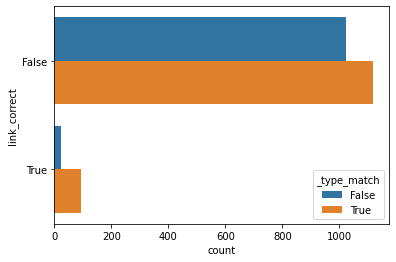

In [6]:
sns.countplot(y="link_correct", hue="_type_match", data=df_annotated);

### 1.1. Planning a Baseline predictor
1. Use **text similarity only** as a predictor of whether an entity mention maps to a SMG record.

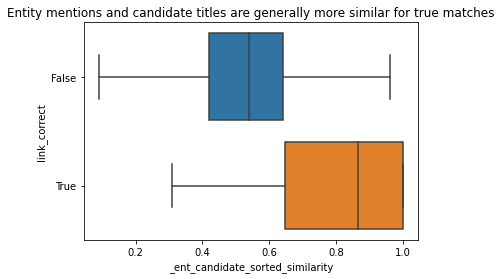

In [7]:
g = sns.boxplot(data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", orient='h', showfliers=False)
g.set_title("Entity mentions and candidate titles are generally more similar for true matches");


2. Use **text similarity and matched type** as a predictor of whether an entity mention maps to an SMG record.

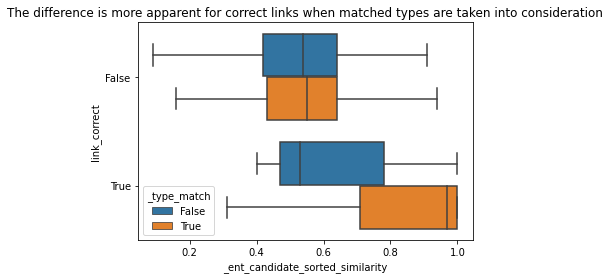

In [8]:
g = sns.boxplot(data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", hue="_type_match", orient='h', showfliers=False)
g.set_title("The difference is more apparent for correct links when matched types are taken into consideration");

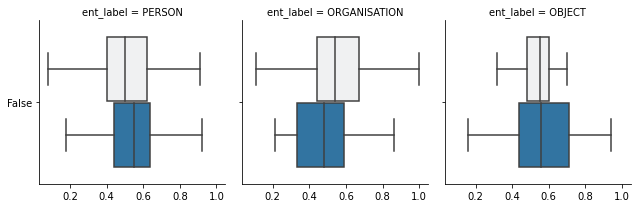

In [9]:
g = sns.FacetGrid(df_annotated, col="ent_label")
g.map_dataframe(sns.boxplot, data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", hue="_type_match", orient='h', showfliers=False)

## 2. Building a Baseline Predictor
- assume an entity mention and record are linked if `fuzz.token_sort_ratio(ent_mention, record_title)` is greater than a threshold, and the predicted entity mention type is the same as the record type
- set this threshold initially to 0.8 based on the above plot and then tune it for accuracy

In [10]:
threshold = 0.8
sim_metric_col = "_ent_candidate_sorted_similarity"

df_annotated['baseline_prediction'] = (df_annotated[sim_metric_col] >= threshold) & (df_annotated["_type_match"])

In [11]:
def calc_metrics(data, gt_col, pred_col):
    tp = len(data[data[gt_col] & data[pred_col]])
    fp = len(data[~data[gt_col] & data[pred_col]])
    tn = len(data[~data[gt_col] & ~data[pred_col]])
    fn = len(data[data[gt_col] & ~data[pred_col]])
    
    try:
        acc = (tp + tn) / (tp + fp + tn + fn)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
        f1 = (2 * pr * re) / (pr + re)

        return {"f1": f1, "precision": pr, "recall": re, "accuracy": acc}
    
    except ZeroDivisionError:
        print("zero division error")
        return {"tp": tp, "fp": fp, "tn": tn, "fn": fn}
    

print("OVERALL")
print(calc_metrics(df_annotated, 'link_correct', 'baseline_prediction'))

for t in ["PERSON", "OBJECT", "ORGANISATION"]:
    print(t)
    print(calc_metrics(df_annotated.loc[df_annotated["ent_label"] == t, :], 'link_correct', 'baseline_prediction'))

OVERALL
{'f1': 0.4796747967479675, 'precision': 0.4609375, 'recall': 0.5, 'accuracy': 0.9434129089301503}
PERSON
{'f1': 0.6713286713286712, 'precision': 0.6575342465753424, 'recall': 0.6857142857142857, 'accuracy': 0.9592720970537262}
OBJECT
zero division error
{'tp': 0, 'fp': 38, 'tn': 232, 'fn': 0}
ORGANISATION
{'f1': 0.3384615384615385, 'precision': 0.6470588235294118, 'recall': 0.22916666666666666, 'accuracy': 0.9486873508353222}


In [12]:
for threshold in (0.6, 0.7, 0.75, 0.8, 0.85):
    df_annotated['baseline_prediction'] = (df_annotated[sim_metric_col] >= threshold) & (df_annotated["_type_match"])
    
    print(f"--- {threshold} ---")
    print(calc_metrics(df_annotated, 'link_correct', 'baseline_prediction'))

    for t in ["PERSON", "OBJECT", "ORGANISATION"]:
        print(t)
        print(calc_metrics(df_annotated.loc[df_annotated["ent_label"] == t, :], 'link_correct', 'baseline_prediction'))

--- 0.6 ---
{'f1': 0.27805695142378556, 'precision': 0.1732776617954071, 'recall': 0.7033898305084746, 'accuracy': 0.8094606542882405}
PERSON
{'f1': 0.32898172323759794, 'precision': 0.2012779552715655, 'recall': 0.9, 'accuracy': 0.7772963604852686}
OBJECT
zero division error
{'tp': 0, 'fp': 89, 'tn': 181, 'fn': 0}
ORGANISATION
{'f1': 0.32, 'precision': 0.2597402597402597, 'recall': 0.4166666666666667, 'accuracy': 0.8985680190930787}
--- 0.7 ---
{'f1': 0.39566395663956644, 'precision': 0.2908366533864542, 'recall': 0.6186440677966102, 'accuracy': 0.9014146772767463}
PERSON
{'f1': 0.5198237885462555, 'precision': 0.37579617834394907, 'recall': 0.8428571428571429, 'accuracy': 0.9055459272097054}
OBJECT
zero division error
{'tp': 0, 'fp': 60, 'tn': 210, 'fn': 0}
ORGANISATION
{'f1': 0.34146341463414637, 'precision': 0.4117647058823529, 'recall': 0.2916666666666667, 'accuracy': 0.9355608591885441}
--- 0.75 ---
{'f1': 0.4647887323943662, 'precision': 0.39759036144578314, 'recall': 0.55932203

## 3. Building a machine learning predictor
Using only the mention, title, and types of each.

In [13]:
f = NELFeatureGenerator()
f = f.fit(df_annotated, ent_mention_col='ent_text', ent_type_col='ent_label', ent_context_col='item_description', 
        candidate_title_col='candidate_title', candidate_type_col='candidate_type', candidate_context_col='candidate_description')

X = f.transform(df_annotated)

X.shape
y = list(1*(df_annotated['link_correct'].values))

2021-09-07 14:52:34,935 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (1/2)
2021-09-07 14:52:45,127 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (2/2)


In [14]:
X.shape, len(y)

((2262, 16), 2262)

In [15]:
f.column_names, f.feature_names

({'ent_mention_col': 'ent_text',
  'ent_context_col': 'item_description',
  'ent_type_col': 'ent_label',
  'candidate_title_col': 'candidate_title',
  'candidate_context_col': 'candidate_description',
  'candidate_type_col': 'candidate_type'},
 ['fuzz_sort similarity (mention-title)',
  'levenshtein similarity (mention-title)',
  'jaro-winkler similarity (mention-title)',
  'fuzz_sort similarity, ignoring suffixes (mention-title)',
  'jaro-winkler similarity (context-context)',
  'jaccard similarity (context-context)',
  'sorensen-dice similarity (context-context)',
  'label is in mention',
  'mention is in label',
  'entity type (OBJECT)',
  'entity type (ORGANISATION)',
  'entity type (PERSON)',
  'candidate type (OBJECT)',
  'candidate type (ORGANISATION)',
  'candidate type (PERSON)',
  'sBERT embedding cosine similarity (context-context)'])

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier

def test_classifiers(X, y):
    all_scores = {}
    
    # SVM
    svm = SVC(random_state=0, kernel='linear', probability=True)
    scores = cross_validate(svm, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['SVM'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    # logistic regression
    log_r = LogisticRegressionCV(cv=5, random_state=0, max_iter=500).fit(X, list(y))

    scores = cross_validate(log_r, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['logr'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    # MLP    
    mlp = MLPClassifier(random_state=0, max_iter=1000)

    scores = cross_validate(mlp, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['MLP'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    return (svm, log_r, mlp), all_scores

(svm, log_r, mlp), scores = test_classifiers(X, y)
scores

/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'SVM': ((0.8668271127955741, 0.15107172614584663),
  (0.6975238419842854, 0.09362987279407167)),
 'logr': ((0.8482240059062377, 0.15853382591025902),
  (0.7129381293921611, 0.10915978664718072)),
 'MLP': ((0.8475479307862175, 0.14794068976092947),
  (0.7502622124307626, 0.10851699426610716))}

### 3.1 Test on unannotated data

In [17]:
df_unannotated_sample = df_unannotated.head(10000)
X_un = f.transform(df_unannotated_sample)

X_un.shape

2021-09-07 14:55:30,566 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (1/2)
2021-09-07 14:56:11,829 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (2/2)


(10000, 16)

In [30]:
threshold = 0.8

classifier = mlp.fit(X, y)

# feature importance if classifier is an SVM with a linear kernel
# print([(idx, coef**2) for idx,coef in enumerate(list(classifier.coef_[0]))])

df_unannotated_sample['log_r_prediction'] = classifier.predict(X_un)
df_unannotated_sample['log_r_prediction_proba'] = classifier.predict_proba(X_un)[:,1]

df_unannotated_sample[(df_unannotated_sample['ent_text'] != df_unannotated_sample['candidate_title'])&(df_unannotated_sample['log_r_prediction_proba'] >= threshold)].sort_values("log_r_prediction_proba", ascending=True).head(100)[[
    'candidate_rank', 
    'item_uri', 
    'item_description', 
    'ent_label',
    'ent_text', 
    'candidate_title', 
    'candidate_type', 
    'candidate_description',
    'candidate_uri', 
    'log_r_prediction', 
    'log_r_prediction_proba']]



,candidate_rank,item_uri,item_description,ent_label,ent_text,candidate_title,candidate_type,candidate_description,candidate_uri,log_r_prediction,log_r_prediction_proba
6827,2,http://collections.vam.ac.uk/item/O235584,"Photograph of Amy Roselle._x000D_ _x000D_ Photography was a novel and exciting development in Victorian days. Most actors and actresses had studio photographs taken, in everyday dress or theatrical costume, for ‘cartes de visite’, and later ‘cabinet cards’. Both were albumen prints made from glass negatives, attached to stiff card backing printed with the photographer’s name. _x000D_ _x000D_ ‘Cartes de visite’, the size of formal visiting cards, were patented in 1854 and produced in their millions during the 1860s when it became fashionable to collect them. Their subjects included scenic views, tourist attractions and works of art, as well as portraits. They were superseded in the late 1870s by the larger and sturdier ‘cabinet cards’ whose popularity waned in turn during the 1890s in favour of postcards and studio portraits._x000D_ _x000D_ This photograph comes from a large collection of ‘cartes de visite’ and ‘cabinet cards’ removed from their backings and mounted in albums by Guy Tristram Little (d.1953) who bequeathed them to the V&A. A collector of greetings cards, games and photographs, Guy Little was a partner in the legal firm Messrs Milles Jennings White & Foster, and the solicitor and executor of Mrs. Gabrielle Enthoven, whose theatrical collection formed the basis of the Theatre Collections at the V&A. Sepia photograph of Amy Roselle.",PERSON,Gabrielle Enthoven,Mrs. Gabrielle Enthoven,PERSON,"Gabrielle Enthoven (1868-1950) was a collector of theatrical memorabilia relating to the London stage whose collection became the basis of the Department of Theatre and Performance at the Victoria and Albert Museum. She.started her remarkable collection in the 1890s, in her flat in Cadogan Gardens. As her collection grew she came to the realisation that London was the only European capital without a public collection of theatrical records, and that an institution was needed to take it on as a gift to ensure its future. In 1911 she wrote to The Observer pointing out the need for a central repository of theatrical material that could be generally accessible, suggesting: ‘a comprehensive theatrical section in an existing museum to comprise specimens of all the different branches necessary to the workings of a play from the construction of the theatre, the designing of the scenery and costumes, to the smallest workings necessary in the house. Also a library and a collection of playbills, prints, pictures and relics etc.’_x000D_ _x000D_ After the initial refusal from the director of the Victoria and Albert Museum Cecil Harcourt-Smith to accept her material, Mrs Enthoven remained undeterred; and after the successful and influential International Theatre Exhibition of around 900 theatre designs, brought over from Amsterdam in 1922 and staged at the V&A, Mrs Enthoven renewed her efforts to get the museum to accept her collection and in March 1924 she succeeded.",https://api.vam.ac.uk/v2/objects/search?id_person=AUTH320080,1,0.804360
11694,9,http://collections.vam.ac.uk/item/O1248173,"Jenny Wiener's complex iconic images of measurement are witty explorations of the systems and constraints of mathematics in an aesthetic context. Wiener's practice centres on measurement. She starts from the perception that nothing is as it seems, and uses her analytic mind and quirky humour to question the assumptions and components we use to define and assess, qualify and quantify. Her concern is that we are increasingly reduced to numbers: serial numbers, pin numbers, illogical scorecards, random statistics and units of measurements - measuring everything and nothing. In her practice, she selects measures and then applies forensic dissection to varied subject matter , including famous paintings (notably Crivelli and Cezanne) , or as here, t

### 3.2 What about rows that didn't make the top *n* search results?

*Performance is not great*, but there are only a few samples. This could be fixed by boosting the correct type in the search results.

In [19]:
# add [object,object] row onto end as it doesn't exist in the original data
df_newrows = df_annotated_not_in_search.append(df_annotated.loc[(df_annotated["ent_label"] == "OBJECT") & (df_annotated["candidate_type"] == "OBJECT")].iloc[0])

X_missed = f.transform(df_newrows)


y_missed = list(1*df['link_correct'].values)


2021-09-07 14:59:05,747 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (1/2)
2021-09-07 14:59:05,842 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (2/2)


In [20]:
df_annotated_not_in_search['pred'] = classifier.predict(X_missed)[0:-1]
df_annotated_not_in_search['pred_proba'] = classifier.predict_proba(X_missed)[:-1,1]

df_annotated_not_in_search

,item_uri,item_uri_link,candidate_rank,item_description,ent_label,ent_text,candidate_title,candidate_type,candidate_uri,candidate_uri_link,link_correct,candidate_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity,pred,pred_proba


## 4. Combining into a scikit-learn pipeline
This is similar to the implementation in `heritageconnector.datastore.NERLoader`.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [22]:
pipe = Pipeline([('featgen', NELFeatureGenerator()), ('svc', SVC(random_state=0, kernel='linear', probability=True))])

In [23]:
pipe = pipe.fit(df_annotated, y=list(1*df_annotated['link_correct'].values), featgen__ent_mention_col='ent_text', featgen__ent_type_col='ent_label', featgen__ent_context_col='item_description', 
        featgen__candidate_title_col='candidate_title', featgen__candidate_type_col='candidate_type', featgen__candidate_context_col='candidate_description')

2021-09-07 14:59:24,165 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (1/2)
2021-09-07 14:59:34,278 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (2/2)


In [24]:
df_unannotated_small = df_unannotated.head(500)
y_pred_proba = pipe.predict_proba(df_unannotated_small)
df_unannotated_small['y_pred_proba'] = y_pred_proba[:,1]

2021-09-07 15:00:29,954 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (1/2)
2021-09-07 15:00:32,627 - heritageconnector.nlp.nel - DEBUG - Calculating sBERT embeddings... (2/2)


In [25]:
df_unannotated_small.sort_values("y_pred_proba", ascending=False).head(10)

,item_uri,item_uri_link,candidate_rank,item_description,ent_label,ent_text,candidate_title,candidate_type,candidate_uri,candidate_uri_link,link_correct,candidate_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity,y_pred_proba
108,http://collections.vam.ac.uk/item/O1146851,http://collections.vam.ac.uk/item/O1146851,3,"This image forms part of the Harry Hammond Photographic Collection, acquired by the V&A from the artist in the 1980s. The collection comprises over 9,000 images of the British popular music scene (Tin Pan Alley) in the 1950s and 60s, on the eve of the boom in British pop music. Harry Hammond (1920-2009) was born in London, and was apprenticed at the age of 14 to a Fleet Street studio. He served as a reconnaissance photographer during World War II. By the late 1950s he had developed his specialism of photographing the London pop music scene. David Hughes dressed as Robin Hood, 1957/59.",PERSON,David Hughes,David Hughes,PERSON,https://api.vam.ac.uk/v2/objects/search?id_person=N9120,https://api.vam.ac.uk/v2/objects/search?id_person=N9120,NaN,David Hughes was a fifties pop idol who became a celebrated opera singer. Record contracts and television shows made him a household name by the end of the 1950's. His fans affectionately called him Mr. Heart-Throb. He made a brave decision early in the 1960's to switch to singing in operas. The end of the 1960’s established David in the opera world. He performed at Glyndebourne and worked with the Welsh and English National Opera Companies.,True,0,1.0,1.0,0.913988
75,http://collections.vam.ac.uk/item/O164431,http://collections.vam.ac.uk/item/O164431,0,"Photograph of Ellen Kean._x000D_ _x000D_ Photography was a novel and exciting development in Victorian days. Most actors and actresses had studio photographs taken, in everyday dress or theatrical costume, for ‘cartes de visite’, and later ‘cabinet cards’. Both were albumen prints made from glass negatives, attached to stiff card backing printed with the photographer’s name. _x000D_ _x000D_ ‘Cartes de visite’, the size of formal visiting cards, were patented in 1854 and produced in their millions during the 1860s when it became fashionable to collect them. Their subjects included scenic views, tourist attractions and works of art, as well as portraits. They were superseded in the late 1870s by the larger and sturdier ‘cabinet cards’ whose popularity waned in turn during the 1890s in favour of postcards and studio portraits._x000D_ _x000D_ This photograph comes from a large collection of ‘cartes de visite’ and ‘cabinet cards’ removed from their backings and mounted in albums by Guy Tristram Little (d.1953) who bequeathed them to the V&A. A collector of greetings cards, games and photographs, Guy Little was a partner in the legal firm Messrs Milles Jennings White & Foster, and the solicitor and executor of Mrs. Gabrielle Enthoven, whose theatrical collection formed the basis of the Theatre Collections at the V&A. Sepia photograph of Ellen Kean.",PERSON,Ellen Kean,Ellen Kean,PERSON,https://api.vam.ac.uk/v2/objects/search?id_person=N6167,https://api.vam.ac.uk/v2/objects/search?id_person=N6167,NaN,"Actress, she first appeared as Olivia to her sister Maria's Viola in an operatic 'Twelfth Night' at a private theatre in Berwick Street, London and her public début was in the same role at Covent Garden in 1822. After touring with her sister she played two seasons at Bath from February 1824, appearing first as Lydia Languish in 'The Rivals'. She spent the summer of 1826 in Birmingham and was then engaged at Drury Lane for three seasons, acting at the Haymarket during the summer. She came to prominence in 1829 when she played Lady Townly in 'The Provoked Husband' at Covent Garden and went on to have a particular success playing Romeo to Fanny Kemble's Juliet._x000D_ _x000D_ In 1833 she became engaged to Charles Kean, but family disapproval lead to the engagement being broken off. Between